In [11]:
# Import required libraries and set display configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-resolution plots in Jupyter
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.unicode_minus'] = False

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
CUDA available: False


In [12]:
# Generate synthetic image dataset (simulating simple geometric shapes)
def generate_synthetic_images(n_samples=5000, img_size=28):
    """
    Generate synthetic images with simple geometric patterns
    """
    images = []

    for i in range(n_samples):
        # Create a blank image
        img = np.zeros((img_size, img_size))

        # Randomly select a shape to draw
        shape_type = np.random.choice(['circle', 'square', 'triangle', 'line'])

        # Random position and size
        center_x = np.random.randint(img_size//4, 3*img_size//4)
        center_y = np.random.randint(img_size//4, 3*img_size//4)
        size = np.random.randint(img_size//8, img_size//4)

        if shape_type == 'circle':
            y, x = np.ogrid[:img_size, :img_size]
            mask = (x - center_x)**2 + (y - center_y)**2 <= size**2
            img[mask] = 1.0
        elif shape_type == 'square':
            x1 = max(0, center_x - size)
            x2 = min(img_size, center_x + size)
            y1 = max(0, center_y - size)
            y2 = min(img_size, center_y + size)
            img[y1:y2, x1:x2] = 1.0
        elif shape_type == 'triangle':
            # Simple triangle
            x_coords = [center_x, center_x - size, center_x + size]
            y_coords = [center_y - size, center_y + size, center_y + size]
            # Fill triangle (simplified approach)
            for y in range(img_size):
                for x in range(img_size):
                    if (x - x_coords[0]) * (y_coords[1] - y_coords[0]) - (y - y_coords[0]) * (x_coords[1] - x_coords[0]) >= 0 and \
                       (x - x_coords[1]) * (y_coords[2] - y_coords[1]) - (y - y_coords[1]) * (x_coords[2] - x_coords[1]) >= 0 and \
                       (x - x_coords[2]) * (y_coords[0] - y_coords[2]) - (y - y_coords[2]) * (x_coords[0] - x_coords[2]) >= 0:
                        img[y, x] = 1.0
        elif shape_type == 'line':
            angle = np.random.rand() * np.pi
            length = np.random.randint(img_size//4, img_size//2)
            for t in np.linspace(0, length, num=length):
                x = int(center_x + t * np.cos(angle))
                y = int(center_y + t * np.sin(angle))
                if 0 <= x < img_size and 0 <= y < img_size:
                    img[y, x] = 1.0

        # Add some noise
        noise = np.random.normal(0, 0.1, (img_size, img_size))
        img = np.clip(img + noise, 0, 1)

        images.append(img)

    # Convert to tensor format (channels first for PyTorch)
    images = np.array(images).reshape(-1, 1, img_size, img_size).astype('float32')

    return images

# Generate synthetic image dataset
img_size = 28
n_samples = 5000
synthetic_images = generate_synthetic_images(n_samples, img_size)

# Convert to PyTorch tensor
X_tensor = torch.tensor(synthetic_images)

# Display basic information about the dataset
print("Dataset shape:", X_tensor.shape)
print("Value range:", X_tensor.min().item(), "to", X_tensor.max().item())
print("Image dimensions:", X_tensor[0].shape)

# Create data loader
batch_size = 64
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Dataset shape: torch.Size([5000, 1, 28, 28])
Value range: 0.0 to 1.0
Image dimensions: torch.Size([1, 28, 28])


In [13]:
# Data preprocessing pipeline
def preprocess_data(X_tensor):
    """
    Preprocess the dataset: normalize to [-1, 1] range for GAN training
    """
    # Normalize to [-1, 1] range (common practice for GANs with tanh activation)
    X_normalized = (X_tensor - 0.5) / 0.5

    return X_normalized

X_processed = preprocess_data(X_tensor)
dataloader = DataLoader(TensorDataset(X_processed), batch_size=batch_size, shuffle=True)

print("Preprocessed data range:", X_processed.min().item(), "to", X_processed.max().item())
print("Batch size:", batch_size)
print("Number of batches:", len(dataloader))

Preprocessed data range: -1.0 to 1.0
Batch size: 64
Number of batches: 79


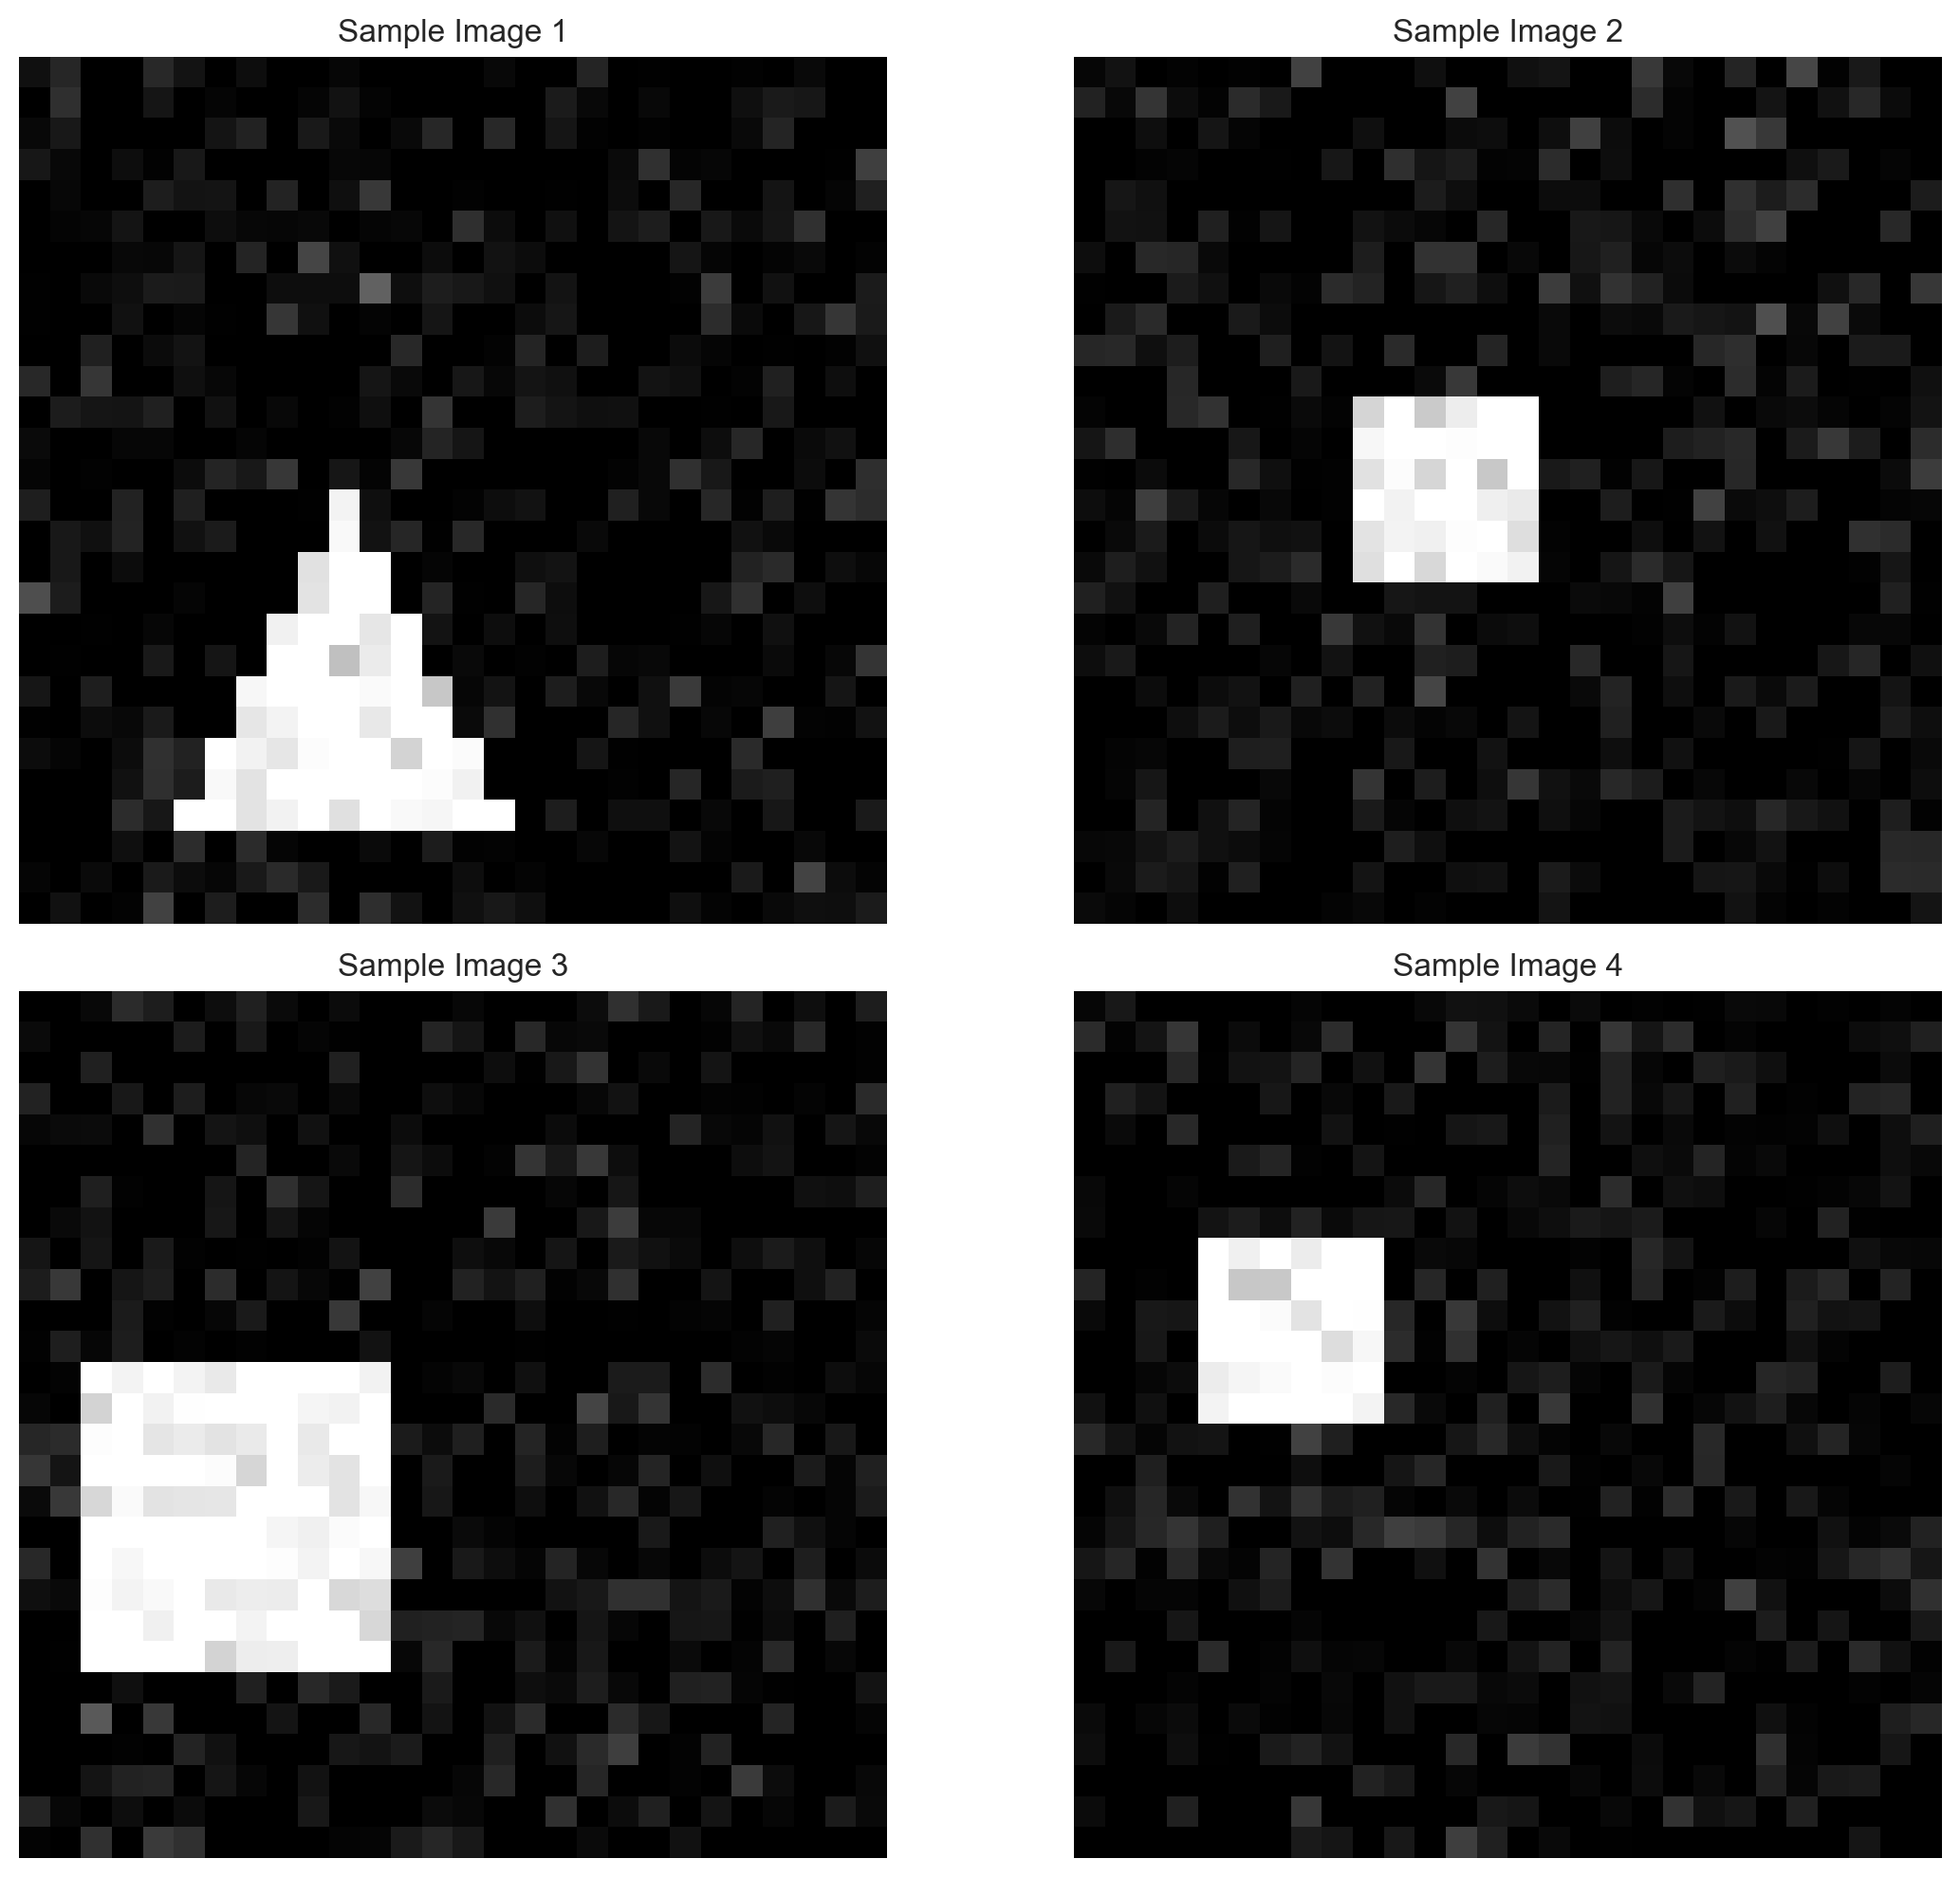

<Figure size 1200x1000 with 0 Axes>

In [14]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2)

# Display sample images from the dataset
for i in range(4):
    row, col = divmod(i, 2)
    axes[row, col].imshow(X_processed[i].squeeze(), cmap='gray')
    axes[row, col].set_title(f'Sample Image {i+1}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Distribution of pixel values
all_pixel_values = X_processed.flatten().numpy()
axes[0,0].hist(all_pixel_values, bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribution of Pixel Values')
axes[0,0].set_xlabel('Pixel Value')
axes[0,0].set_ylabel('Frequency')

# Average image
avg_image = torch.mean(X_processed, dim=0)
axes[0,1].imshow(avg_image.squeeze(), cmap='gray')
axes[0,1].set_title('Average Image')
axes[0,1].axis('off')

# Pixel value statistics
axes[1,0].boxplot([all_pixel_values[all_pixel_values < 0], all_pixel_values[all_pixel_values >= 0]],
                  labels=['Negative', 'Non-negative'])
axes[1,0].set_title('Pixel Value Distribution (Box Plot)')
axes[1,0].set_ylabel('Pixel Value')

# Show some variations in the dataset
for i in range(4):
    sample_idx = np.random.randint(0, len(X_processed))
    axes[1,1].imshow(X_processed[sample_idx].squeeze(), cmap='gray', alpha=0.3)
axes[1,1].set_title('Overlapped Sample Images')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Define GAN components: Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_size=100, img_size=28, channels=1):
        super(Generator, self).__init__()

        self.img_size = img_size
        self.channels = channels

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(input_size, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, img_size * img_size * channels),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.channels, self.img_size, self.img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size=28, channels=1):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(channels * img_size ** 2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize generator and discriminator
img_shape = (1, img_size, img_size)
latent_dim = 100

generator = Generator(latent_dim, img_size, 1)
discriminator = Discriminator(img_size, 1)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Display model architectures
print("Generator Architecture:")
print(generator)
print(f"\nTotal generator parameters: {sum(p.numel() for p in generator.parameters())}")

print("\nDiscriminator Architecture:")
print(discriminator)
print(f"\nTotal discriminator parameters: {sum(p.numel() for p in discriminator.parameters())}")

Generator Architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

Total generator parameters: 1510032

Discriminator Architecture:
Discriminator(
  (model): Sequential(
    (0): Linear(in_featu

In [17]:
# Training the GAN
num_epochs = 20
sample_interval = 50

# Lists to store losses for plotting
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for i, (real_imgs,) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(real_imgs.size(0), 1)
        fake = torch.zeros(real_imgs.size(0), 1)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(real_imgs.size(0), latent_dim)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Store losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if i % sample_interval == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training completed!")

[Epoch 0/20] [Batch 0/79] [D loss: 0.4726] [G loss: 1.7175]
[Epoch 0/20] [Batch 50/79] [D loss: 0.4057] [G loss: 0.9902]
[Epoch 1/20] [Batch 0/79] [D loss: 0.3516] [G loss: 1.2771]
[Epoch 1/20] [Batch 50/79] [D loss: 0.5353] [G loss: 1.7895]
[Epoch 2/20] [Batch 0/79] [D loss: 0.4811] [G loss: 1.2801]
[Epoch 2/20] [Batch 50/79] [D loss: 0.4024] [G loss: 1.2968]
[Epoch 3/20] [Batch 0/79] [D loss: 0.5191] [G loss: 0.8428]
[Epoch 3/20] [Batch 50/79] [D loss: 0.5259] [G loss: 0.9587]
[Epoch 4/20] [Batch 0/79] [D loss: 0.5565] [G loss: 0.7207]
[Epoch 4/20] [Batch 50/79] [D loss: 0.5094] [G loss: 0.7494]
[Epoch 5/20] [Batch 0/79] [D loss: 0.5733] [G loss: 1.8005]
[Epoch 5/20] [Batch 50/79] [D loss: 0.4457] [G loss: 1.2051]
[Epoch 6/20] [Batch 0/79] [D loss: 0.5992] [G loss: 0.8112]
[Epoch 6/20] [Batch 50/79] [D loss: 0.5781] [G loss: 1.0333]
[Epoch 7/20] [Batch 0/79] [D loss: 0.5554] [G loss: 0.8511]
[Epoch 7/20] [Batch 50/79] [D loss: 0.5777] [G loss: 0.9999]
[Epoch 8/20] [Batch 0/79] [D los

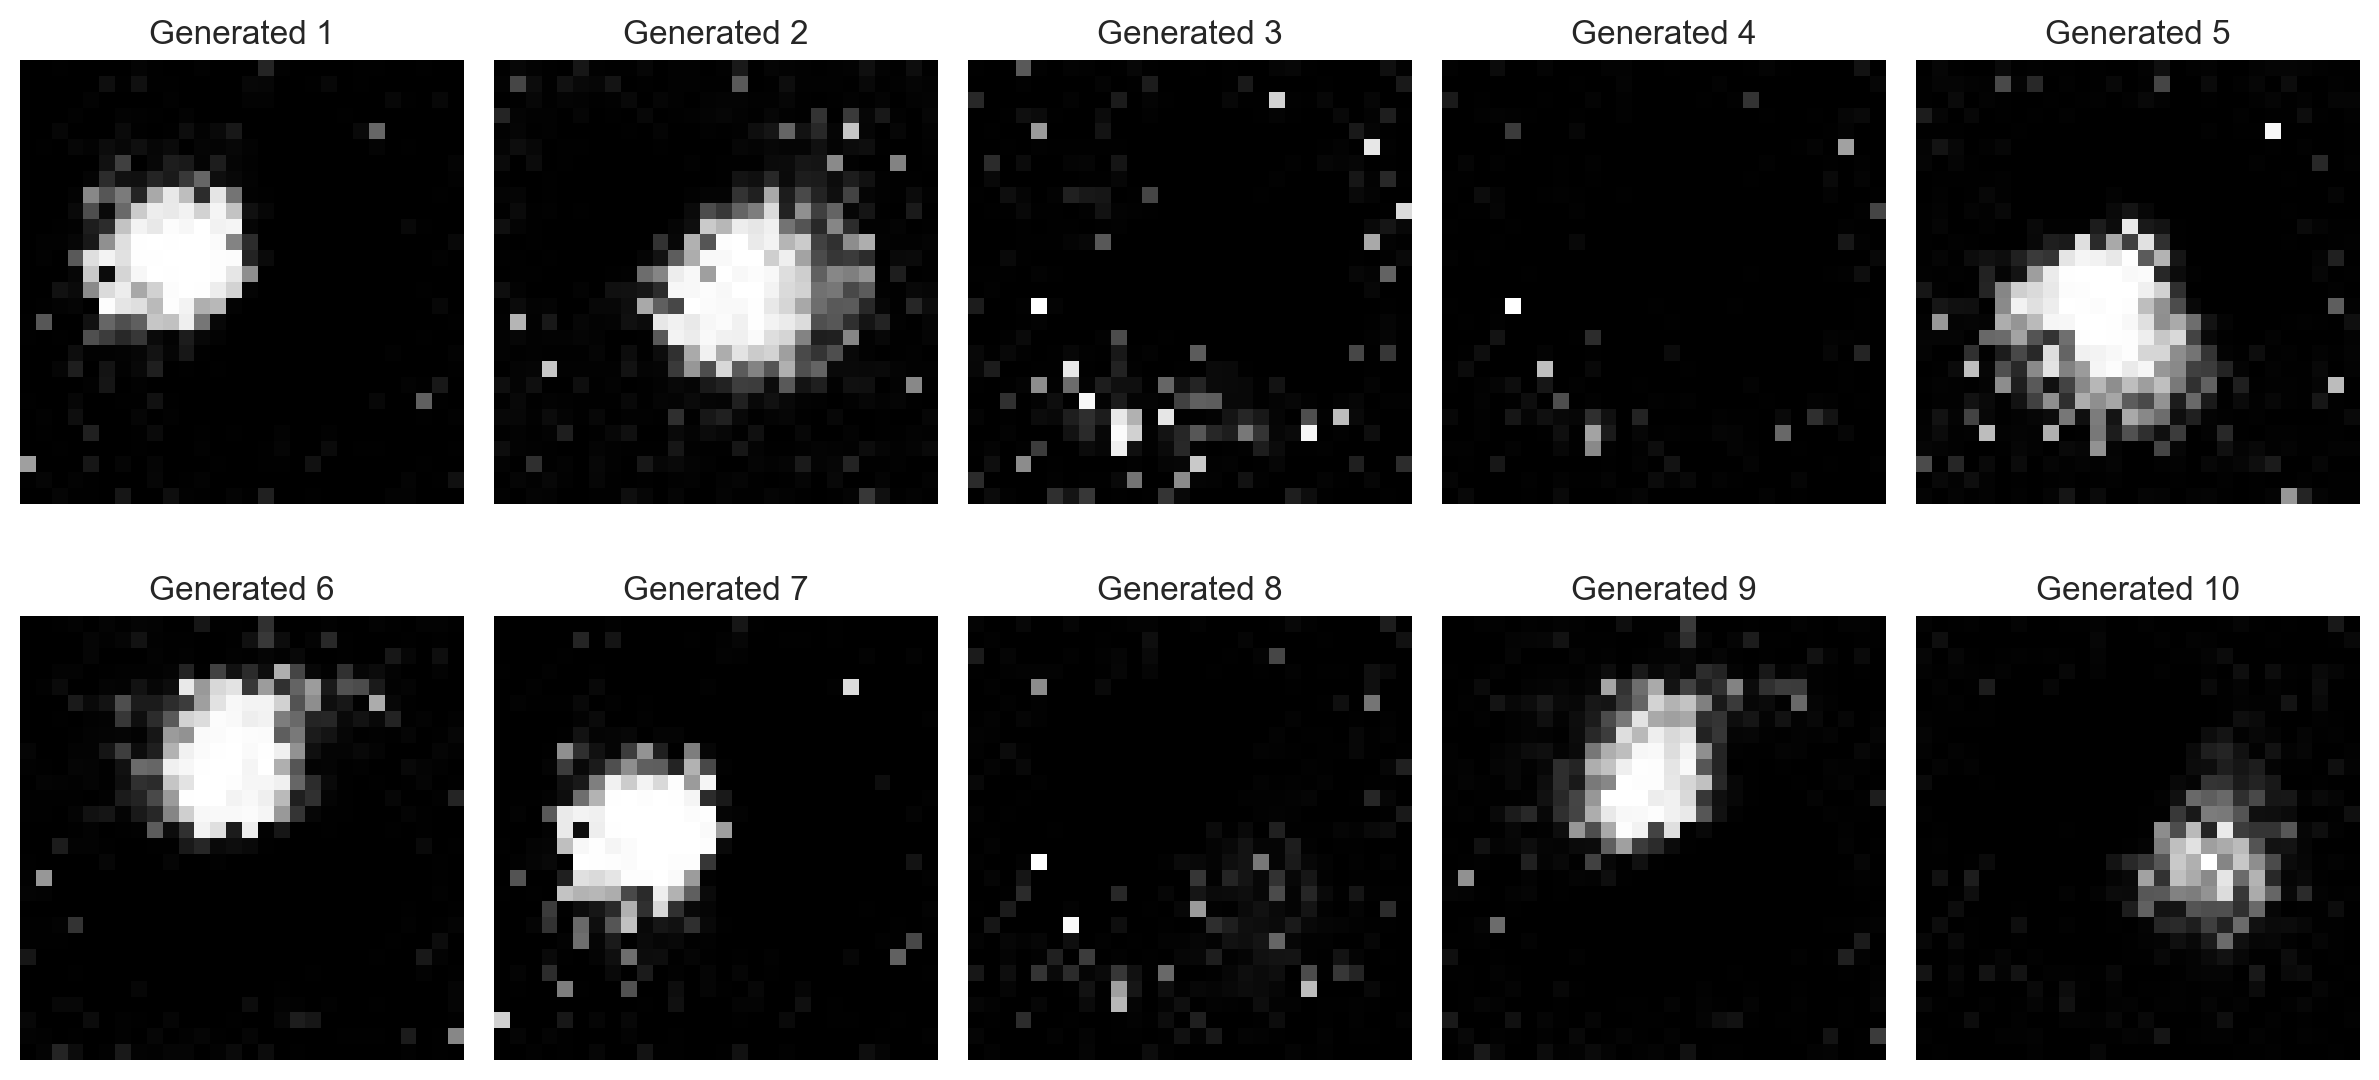

In [18]:
# Generate and visualize sample images from the trained generator
def show_generated_images(generator, num_samples=10, latent_dim=100):
    """
    Generate and display sample images from the trained generator
    """
    generator.eval()
    with torch.no_grad():
        # Sample random noise
        z = torch.randn(num_samples, latent_dim)
        # Generate images
        gen_imgs = generator(z)
        # Denormalize images back to [0, 1] range
        gen_imgs = (gen_imgs + 1) / 2.0

    # Plot generated images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(num_samples):
        ax = axes[i//5, i%5]
        ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
        ax.set_title(f'Generated {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return gen_imgs

# Show generated images
generated_images = show_generated_images(generator, num_samples=10, latent_dim=latent_dim)

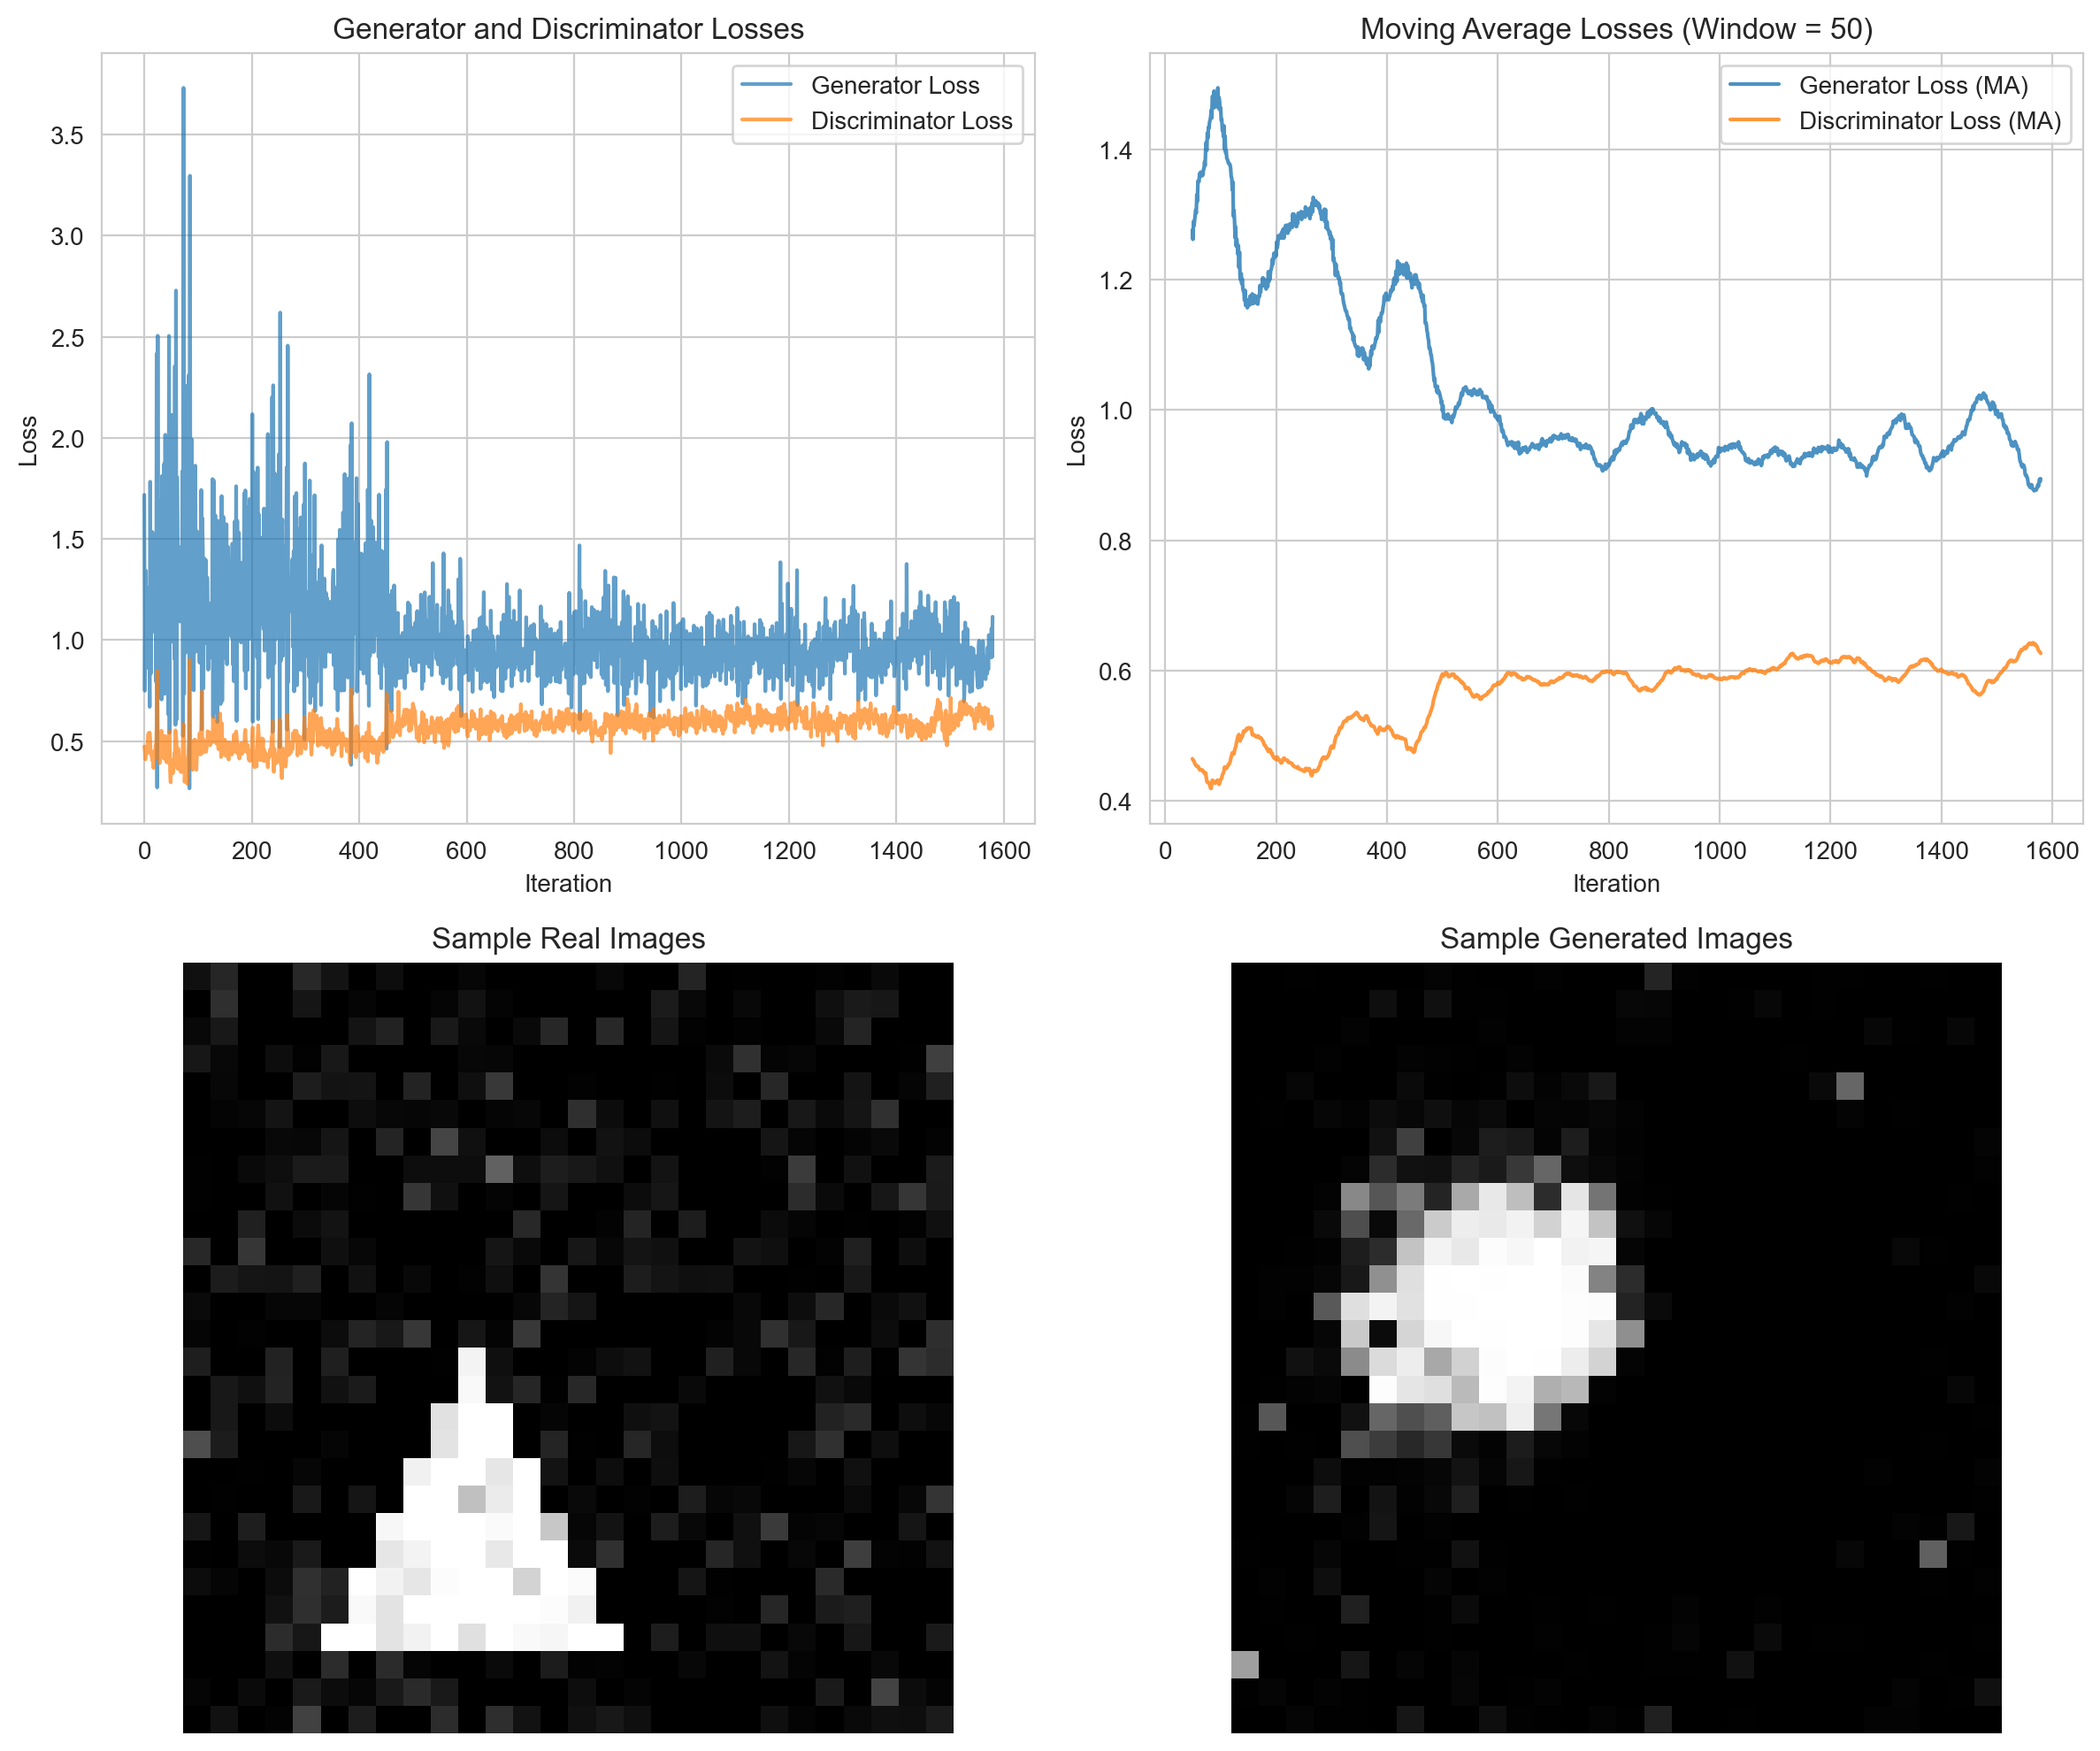

Image Quality Metrics:
Real images - Mean: -0.7935, Std: 0.4804
Generated images - Mean: 0.0775, Std: 0.2157
Mean difference: 0.8710
Std difference: 0.2647


In [19]:
# Visualization of training results
fig, axes = plt.subplots(2, 2)

# Generator and Discriminator losses
axes[0,0].plot(g_losses, label='Generator Loss', alpha=0.7)
axes[0,0].plot(d_losses, label='Discriminator Loss', alpha=0.7)
axes[0,0].set_title('Generator and Discriminator Losses')
axes[0,0].set_xlabel('Iteration')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()

# Moving average of losses to see trends better
window_size = 50
if len(g_losses) > window_size:
    g_losses_ma = pd.Series(g_losses).rolling(window=window_size).mean()
    d_losses_ma = pd.Series(d_losses).rolling(window=window_size).mean()

    axes[0,1].plot(g_losses_ma, label='Generator Loss (MA)', alpha=0.8)
    axes[0,1].plot(d_losses_ma, label='Discriminator Loss (MA)', alpha=0.8)
    axes[0,1].set_title(f'Moving Average Losses (Window = {window_size})')
    axes[0,1].set_xlabel('Iteration')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()

# Compare real vs generated images
real_samples = X_processed[:5]
gen_samples = generated_images[:5]

# Real images
for i in range(5):
    ax = axes[1,0] if i == 0 else axes[1,1] if i == 1 else None
    if ax:
        ax.imshow(real_samples[i].squeeze(), cmap='gray')
        ax.set_title('Sample Real Images')
        ax.axis('off')

# Generated images
for i in range(5):
    ax = axes[1,1] if i == 0 else None
    if ax and i == 0:
        ax.imshow(gen_samples[i].squeeze(), cmap='gray')
        ax.set_title('Sample Generated Images')
        ax.axis('off')

# If we couldn't fit in the above structure, create a separate plot
if len(axes[1]) > 1 and axes[1,0].get_title() == '':
    axes[1,0].imshow(real_samples[0].squeeze(), cmap='gray')
    axes[1,0].set_title('Sample Real Image')
    axes[1,0].axis('off')

if len(axes[1]) > 1 and axes[1,1].get_title() == '':
    axes[1,1].imshow(gen_samples[0].squeeze(), cmap='gray')
    axes[1,1].set_title('Sample Generated Image')
    axes[1,1].axis('off')

plt.tight_layout()
plt.show()

# Calculate and display some metrics
def calculate_image_quality_metrics(real_images, generated_images):
    """
    Calculate basic quality metrics between real and generated images
    """
    # Simple metrics: mean and std comparison
    real_mean = real_images.mean().item()
    real_std = real_images.std().item()
    gen_mean = generated_images.mean().item()
    gen_std = generated_images.std().item()

    print("Image Quality Metrics:")
    print(f"Real images - Mean: {real_mean:.4f}, Std: {real_std:.4f}")
    print(f"Generated images - Mean: {gen_mean:.4f}, Std: {gen_std:.4f}")
    print(f"Mean difference: {abs(real_mean - gen_mean):.4f}")
    print(f"Std difference: {abs(real_std - gen_std):.4f}")

calculate_image_quality_metrics(X_processed[:100], generated_images)

GAN Model Configuration:
Generator input (latent) dimension: 100
Image size: 28x28
Image channels: 1 (grayscale)
Training epochs: 20
Batch size: 64

Final Loss Values:
Final Generator Loss: 1.1149
Final Discriminator Loss: 0.5739

Exploring Latent Space - Generating 5 samples with different random inputs:


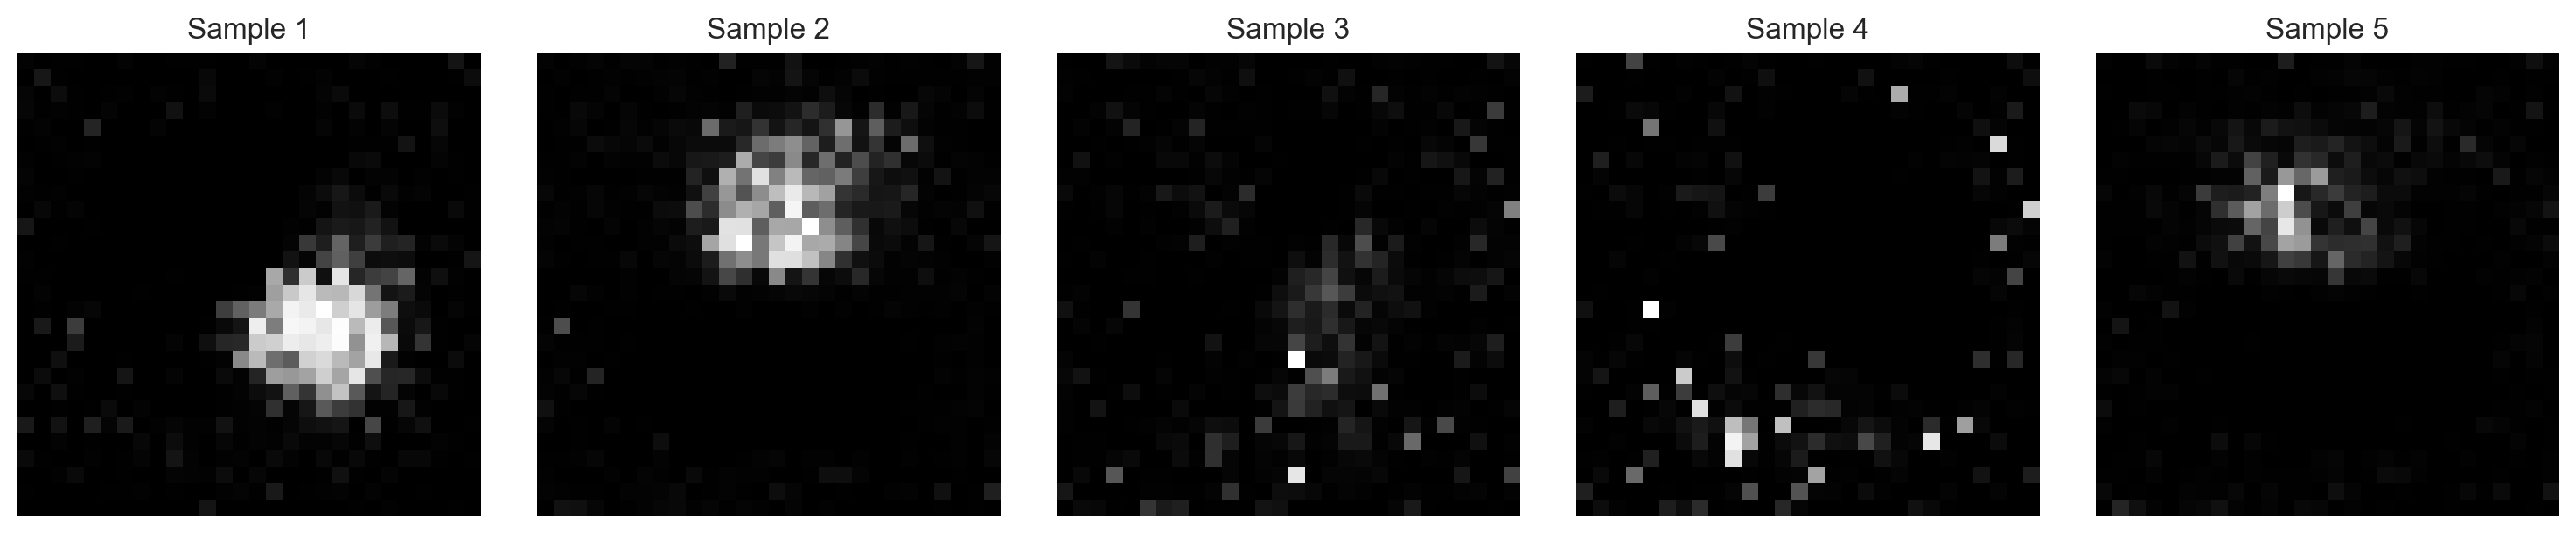


Interpolating between two random points in latent space (5 steps):


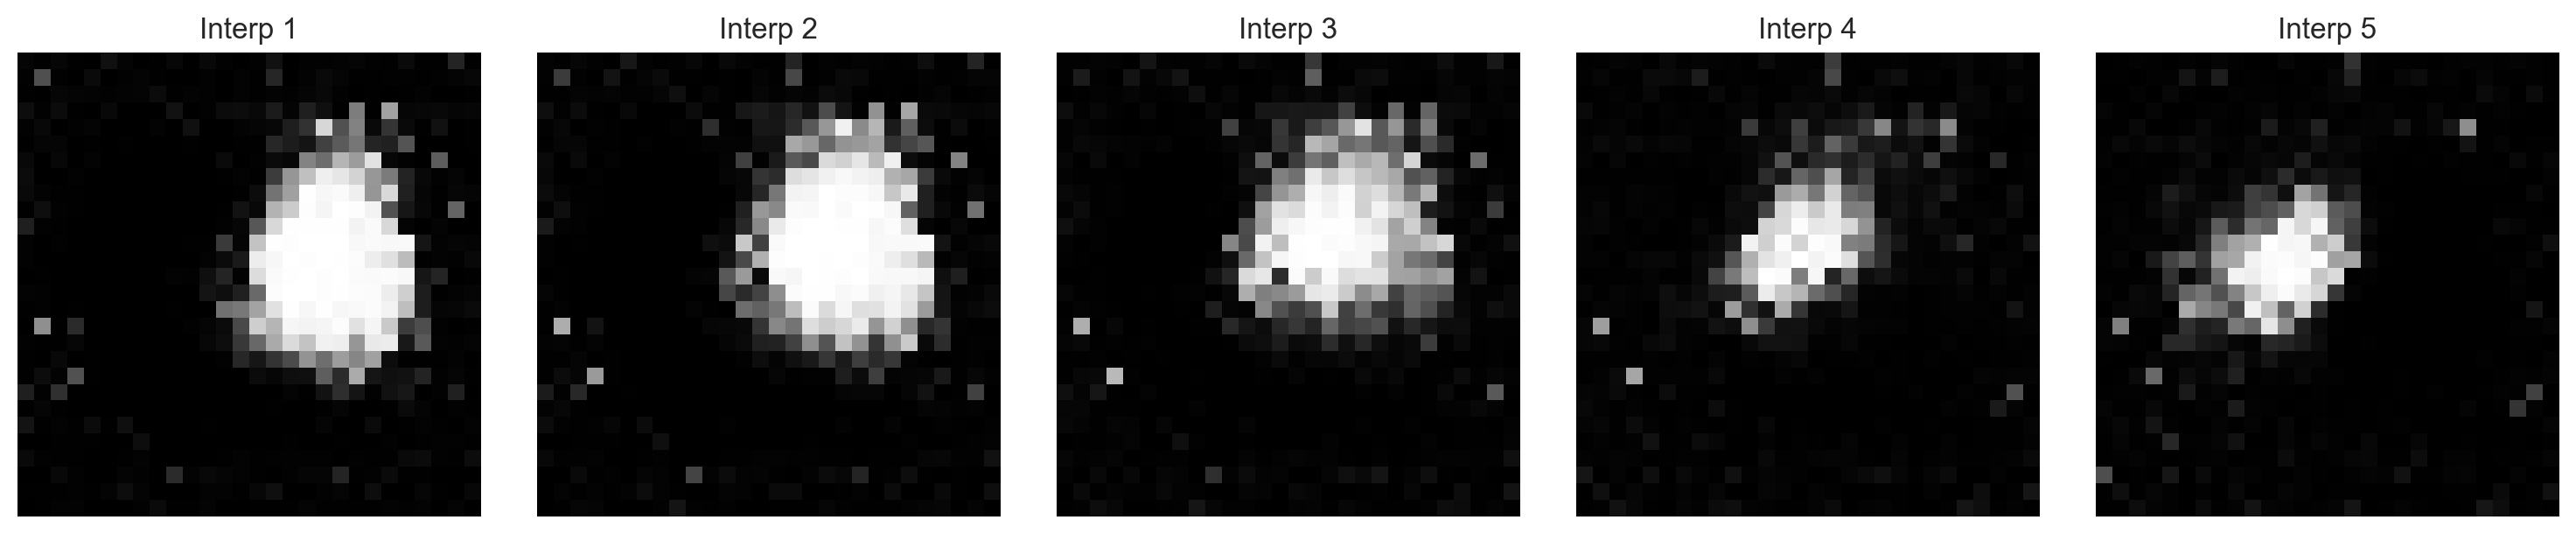

In [20]:
# Model interpretation and insights
print("GAN Model Configuration:")
print(f"Generator input (latent) dimension: {latent_dim}")
print(f"Image size: {img_size}x{img_size}")
print(f"Image channels: 1 (grayscale)")
print(f"Training epochs: {num_epochs}")
print(f"Batch size: {batch_size}")

print(f"\nFinal Loss Values:")
if g_losses:
    print(f"Final Generator Loss: {g_losses[-1]:.4f}")
if d_losses:
    print(f"Final Discriminator Loss: {d_losses[-1]:.4f}")

# Show how the generator responds to different inputs
def explore_latent_space(generator, latent_dim=100, num_samples=5):
    """
    Explore how the generator responds to different latent vectors
    """
    print(f"\nExploring Latent Space - Generating {num_samples} samples with different random inputs:")

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        z = torch.randn(1, latent_dim)
        gen_img = generator(z)
        gen_img = (gen_img + 1) / 2.0  # Denormalize

        axes[i].imshow(gen_img.squeeze().detach().numpy(), cmap='gray')
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

explore_latent_space(generator, latent_dim=latent_dim, num_samples=5)

# Show interpolation between two points in latent space
def interpolate_latent_space(generator, latent_dim=100, steps=5):
    """
    Interpolate between two random points in latent space
    """
    print(f"\nInterpolating between two random points in latent space ({steps} steps):")

    # Generate two random latent vectors
    z1 = torch.randn(1, latent_dim)
    z2 = torch.randn(1, latent_dim)

    fig, axes = plt.subplots(1, steps, figsize=(15, 3))

    for i in range(steps):
        # Interpolate between z1 and z2
        alpha = i / (steps - 1)
        z_interp = (1 - alpha) * z1 + alpha * z2

        # Generate image
        gen_img = generator(z_interp)
        gen_img = (gen_img + 1) / 2.0  # Denormalize

        axes[i].imshow(gen_img.squeeze().detach().numpy(), cmap='gray')
        axes[i].set_title(f'Interp {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

interpolate_latent_space(generator, latent_dim=latent_dim, steps=5)